## Gaussian process regression on faces dataset ##

Importing necessary packages

In [1]:
import numpy as np
from scipy import spatial, optimize
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.pylab as plt
import vtk
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
import os
from scipy import spatial
from sklearn.decomposition import PCA


Bad key text.latex.preview in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an

Defining preprocessing and visualization functions

In [2]:
def readfile(filename):
    """Function : Reads the shape's cooridinates from a vtk file
        Inputs : 
             - filename : the path to the vtk file 
        Output : 
             - numpy_cells : the mesh wiring 
             - numpy_nodes : the mesh points 
    """
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    """Function : Save a shape in a given vtk file
        Inputs : 
             - points : the mesh points
             - cell : the mesh wiring 
             - filename : the path to the vtk file 
    """
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):
    """Function : Visualize a shape saved in a given file
        Inputs : 
             - filename : the path to the vtk file  
    """

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def unmake_xy(shape):
    """Function : Unflattens a shape that has 1D vector format to 3D fromat
        Inputs : 
             - shape : vector of concatenated point's coordinates 
        Output :
             - Shape_3d : list of the 3D points of the shape
    """
    return np.vstack([shape[range(0, len(shape), 3)],shape[range(1, len(shape), 3)], shape[range(2, len(shape), 3)]]).T

def make_xy(hand) :
    """Function : Flattens a shape that has 3D vector format to 1D format
        Inputs : 
             - Shape_3d : list of the 3D points of the shape
        Output :
             - shape : vector of concatenated point's coordinates 
             
    """
    return hand.flatten()

def My_Visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    """Function : Visualize multiple 3D shapes and scatter some given points
        Inputs : 
             - Faces_List : the list of the 3D meshes (Tables of points)
             - Wiring : the cells table that describs the how the points are linked in the mesh
             - colors : list of the colors of each mesh
             - Scatter : Indexes of the points to scatter in the shape
    """
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 2
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

Defining gaussian process regressors class

In [3]:
# This class will define the gaussian process regressors for general use 

class GPregressor :
    def __init__(self, Input_dim, Nb_points, kernel):
        """Initializing the GPR parameters :
            Inputs : 
                - Input_dim : the dimentionality of the input (in 3D shapes Input_dim=3) 
                - Nb_points : the number of points in the training dataset
                - kernel : the covariance function it will use
        """
        self.dim_i = Input_dim
        self.Nb = Nb_points
        self.kernel = kernel
        self.Cov_mat = []

    def unmake_xy(self, hand):
        """Function : Unflattens a shape that has 1D vector format to 3D fromat
        Inputs : 
             - shape : vector of concatenated point's coordinates 
        Output :
             - Shape_3d : list of the 3D points of the shape
        """
        return np.vstack([hand[range(0, len(hand), 3)], hand[range(1, len(hand), 3)], hand[range(2, len(hand), 3)]]).T

    def make_xy(self, hand) :
        """Function : Flattens a shape that has 3D vector format to 1D format
        Inputs : 
             - Shape_3d : list of the 3D points of the shape
        Output :
             - shape : vector of concatenated point's coordinates 
             
        """
        return hand.flatten()

    def Cov_func(self, Points):
        """Function : Computes the reduced covariance matrix given a list of points using the specified kernel"""
        #kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001)
        return self.kernel(Points)

    def fit(self, Training_shapes) :

        """Function : Train the model on multiple Training shapes 
            Inputs : 
                - Training_shapes : list of all the shapes in the train dataset
            Outputs :
                - Updates the GPR covariance matrix 
        """

        ## Initializing the reduced cov matrix
        Reduced_cov = np.zeros((self.Nb, self.Nb))
        for i in range(len(Training_shapes)) :
            # Computing the reduced covariance matrix for each shape deformation in the training set
            Reduced_cov += self.Cov_func(self.unmake_xy(Training_shapes[i, :]))

        Reduced_cov /= len(Training_shapes)

        # Computing the covariance matrix from the reduced form 
        Cov_matrix = np.zeros((self.dim_i*Reduced_cov.shape[0], self.dim_i*Reduced_cov.shape[0]))
        for i in range(self.Nb):
            for j in range(self.Nb) :
                Cov_matrix[self.dim_i*i:self.dim_i*(i+1), self.dim_i*j:self.dim_i*(j+1)] = Reduced_cov[i, j]*np.eye(self.dim_i)
        
        self.Cov_mat = Cov_matrix

    def predict(self, Incomplete_shape, Indexes) :
        """Function : Predicts the missing regions of an incompete mesh
            Inputs : 
                - Incomplete_shape : a flat vector representing the mesh 
                - Indexes : list of the missing points Indexes
            Outputs :
                - Zipped_data : return the complete input shape by filling the missing nodes 
        """

        # Defining the set of observed deformation 
        observed_points = Incomplete_shape[Indexes==1]

        # Defining the blocks of covariance matrix 
        Kxy = self.Cov_mat[Indexes==0, :][:, Indexes==1]
        Kyy = self.Cov_mat[Indexes==1, :][:, Indexes==1]

        # Computing the posterior mean shape
        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        # Combining the predicted deformations with the observed ones 
        Zipped_data = np.zeros(Incomplete_shape.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points

        return Zipped_data

Reading and preprocessing (Aligning) the data

In [4]:
## Reading the shapes already aligned (using proscrutes) and stored in Aligned_data folder 
path = '../../Aligned_data/'

L = os.listdir(path)
Dataset = []
Wiring = []

for f in L :
    if 'vtk' in f :
       Tab, Tob = readfile(path+f)
       Dataset.append(make_xy(Tob))
       Wiring.append(Tab)
    #My_Visualize([Tob], Tab, ['w'])
    
Dataset = np.array(Dataset[:-1])
Dataset.shape

(10, 159447)

Marking the missing region

In [5]:
def Region(T, center, radius):
    """Function : finds the indexes of the points of the shape that are in the sphere specified by 
    the center and the radius """
    Indexes = []
    for i in range(len(T)) :
        if np.linalg.norm(T[i]-center)<radius :
            Indexes.append(i)
    return Indexes

# Defining a region restriction in the face to limit computational time 

Tob = unmake_xy(Dataset[0, :])
Restriction = Region(Tob, [0.0005, 0.0012, 0.004], 0.0032)
print(len(Restriction))


#My_Visualize([Tob], Tab, ['w'], Restriction[1:])

8316


In [6]:
## Creating the restricted dataset on the region of interest

Restricted_Dataset = np.zeros((Dataset.shape[0], len(Restriction)*3))

print(Restricted_Dataset.shape)
for i in range(Dataset.shape[0]) :
    Restricted_Dataset[i] = make_xy(unmake_xy(Dataset[i])[Restriction])

Restricted_Dataset.shape

(10, 24948)


(10, 24948)

In [7]:
# Displaying the noseless shape from a training example

Noseless= unmake_xy(Dataset[-1, :])
Indexes = Region(Noseless, [0.0005, 0.0012, 0.004], 0.00135)

Noseless[Indexes] = 0

# Uncoment to visualize
#My_Visualize([Noseless], Wiring[0], ['w'])

In [8]:
# Defining the missing region that will be reconstructed by the GPR 

Indexes = []
Tob = unmake_xy(Restricted_Dataset[0, :])
Indexes = Region(Tob, [0.0005, 0.0012, 0.004], 0.00135)
print(len(Indexes))

854


In [9]:
from copy import deepcopy

## In this section we will devide the faces on multiple gaussian processes to avoid the memory problem


# Specifying the number of processes
N_process = 9

# Initializing the table that will manage what each process space region is
Decoding = []

for j in range(N_process) :
    L = []
    # We got through the points of the mesh one by one, the first point is taken by the first gaussian process 
    # the second point is taken by the second process and so on
    for i in range(0, Restricted_Dataset.shape[1], 3) :
        if (i//3)%N_process == j :
            L.append(i)
            L.append(i+1)
            L.append(i+2)
    Decoding.append(L)

print(len(Decoding))
    

# Here we specify for each process the indexes of the deformation that it will predict after the training
Regions_decod = deepcopy(Decoding)

for i in range(len(Regions_decod)) :
    for j in range(len(Regions_decod[i])) :
        if (Decoding[i][j]//3 in Indexes) :
            Regions_decod[i][j] = 0 
        else :
            Regions_decod[i][j] = 1

9


In [10]:

# Normalizing the dataset
Dataset /= np.max(Dataset)

# Computing the mean shape
Mean_shape = np.mean(Dataset, axis=0)

# Computing the deformations from the mean shape
Dataset = Dataset - Mean_shape

# Recomputing the restricted dataset after normalizing and centering
Restricted_Dataset = np.zeros((Dataset.shape[0], len(Restriction)*3))

print()
for i in range(Dataset.shape[0]) :
    Restricted_Dataset[i] = make_xy(unmake_xy(Dataset[i])[Restriction])

Mean_shape.shape, Restricted_Dataset.shape

((159447,), (10, 24948))

Augmenting the data 

In [11]:
# Splitting the dataset to train and test
Train_data = Dataset[:9, :]
Test_data = Dataset[9, :]

Train_data.shape, Test_data.shape

((9, 159447), (159447,))

In [12]:
#My_Visualize([ unmake_xy(Test_data)], Wiring[0], colors=['w'])

In [13]:
# Initializing the data augmentation by projecting the train data into the pca plane

pca = PCA(n_components=3)
pca.fit(Train_data)

Y = pca.fit_transform(Train_data)

In [14]:
# defining from the projected points, the bounds of the pca domain from which we will 
m1, M1 = min(Y[:, 0]), max(Y[:, 0])
m2, M2 = min(Y[:, 1]), max(Y[:, 1])
m3, M3 = min(Y[:, 2]), max(Y[:, 2])
M = max(abs(np.array([m1, M1, m2, M2, m3, M3])))

# Sampling random points from the pca space
New_samples = np.random.uniform(-M, M, (11, 3))

# Transforming those sampled points back the shape space 
New_shapes = pca.inverse_transform(New_samples)
New_shapes.shape

(11, 159447)

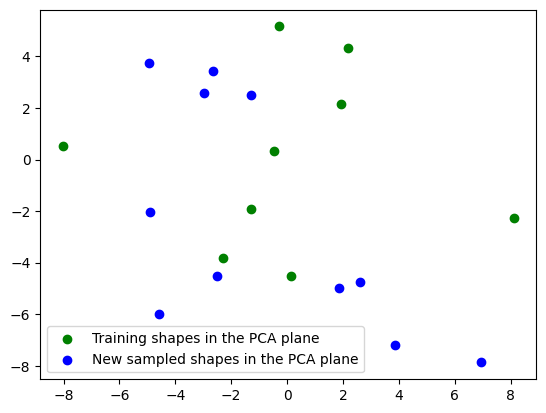

In [15]:
plt.scatter(Y[:, 0], Y[:, 1], label="Training shapes in the PCA plane", c='g')
plt.scatter(New_samples[:, 0], New_samples[:, 1], label="New sampled shapes in the PCA plane", c='b')
plt.legend()
plt.show()

In [16]:
# Adding the new generated shapes to the dataset
Train_data = np.concatenate((Train_data, New_shapes), axis=0)

In [17]:
# Redifining the restricted regions on the new shapes 

Restricted_train_data = np.zeros((Train_data.shape[0], len(Restriction)*3))

for i in range(Train_data.shape[0]) :
    Restricted_train_data[i] = make_xy(unmake_xy(Train_data[i])[Restriction])

Restricted_test_data = np.zeros(len(Restriction)*3)

Restricted_test_data =  make_xy(unmake_xy(Test_data)[Restriction])

Restricted_test_data.shape, Restricted_train_data.shape

((24948,), (20, 24948))

In [18]:
def Accuracy(A, P, R, T_data) :
    """Function : Computing the accuracy metric
        Inputs :
            - A : Mean shape reconstruction
            - P : Predicted reconstruction by GPR
            - R : Real shape 
            - T_data : Training data
        Ouptut :
            - Acc : the accuracy of the reconstruction"""
    
    pca = PCA(n_components=10)
    pca.fit(Restricted_train_data)

    Data = np.zeros((T_data.shape[0]+3, T_data.shape[1]))
    Data[-1, :] = R
    Data[-2, :] = P
    Data[-3, :] = A
    Data[:-3, :] = T_data
    Y = pca.fit_transform(Data)

    return 1-np.linalg.norm(Y[-1]-Y[-2])/np.linalg.norm(Y[-1]-Y[-3])



In [19]:
def Process(params, s) :
    """Function : Initialize, Train and test the multiple GPR with the parameters given
        Inputs :
            - params : [l, nu] the parameters of the matern kernel
            - s : the scalling coeficient of the matern kernel"""

    # Initializing the GPR list 
    GP_net = []

    # Setting the variance of the white noise kernel
    sigma = 0.001
    

    for i in range(N_process) :
        #print("Gaussian Process "+str(i+1)+" started training")

        # Defining the kernel with the given parameters 
        My_kernel = s * Matern(length_scale=params[0], nu=params[1])+ ConstantKernel()+ WhiteKernel(noise_level=sigma)
        
        # Initializing the i-th GPR
        GP = GPregressor(Input_dim=3, Nb_points=len(Decoding[i])//3, kernel=My_kernel)

        # Training the i-th GPR 
        GP.fit(Restricted_train_data[:, Decoding[i]])

        # Saving the model
        GP_net.append(GP)

    # Defining the test shape 
    Test_shape = deepcopy(Restricted_test_data)
    Predicted_shape = np.zeros(Test_shape.shape)

    for i in range(N_process) :
        #print("GP " + str(i)+" is processing the missing points")

        # Predicting the part of the missing points by the i-th gaussian process
        Test_shape_i = Test_shape[Decoding[i]]
        Predicted_points = GP_net[i].predict(Test_shape_i, np.array(Regions_decod[i]))
        Predicted_shape[Decoding[i]] = Predicted_points

    # Defining the average reconstruction by replacing the missing nose with the average nose
    Average_reconstruction = deepcopy(Test_shape)
    for i in range(N_process) :
        for j in range(len(Decoding[i])) :
            if Regions_decod[i][j] == 0 :
                Average_reconstruction[Decoding[i][j]] = 0

    # transforming the average , predicted, real shapes to 3D format for displaying 

    A = deepcopy(unmake_xy(Test_data))
    A[Restriction, :] = unmake_xy(Average_reconstruction)
    A += unmake_xy(Mean_shape)

    P = deepcopy(unmake_xy(Test_data))
    P[Restriction, :] = unmake_xy(Predicted_shape)
    P += unmake_xy(Mean_shape)

    R = deepcopy(unmake_xy(Test_data))
    R += unmake_xy(Mean_shape)

    #My_Visualize([A, P, R], Wiring[0], ['w', 'w', 'w'])

    # Computing the accuracy of the prediction
    Acc =  Accuracy(Average_reconstruction, Predicted_shape, Test_shape, Restricted_train_data)
    return Acc, A, R, P


In [20]:
#Those are the best parameters we found for the reconstruction

l = 0.5
Nu = 1.5
s = 10

Acc, A, R, P= Process([l, Nu], s)

print("Accuracy --> "+ str(round(Acc*100, 2)) + " %")


Accuracy --> 97.87 %


In [21]:
My_Visualize([A, P, R], Wiring[0], ['r', 'w', 'g'])

In [22]:
# this section tries multiple kernel parameters values to find the optimal ones
# Warning it takes a lot of computational time since it evalutes the reconstruction for 64 combination of params

"""l_range = np.linspace(0.1, 3, 4)
Nu_range = np.linspace(0.1, 1.5, 4)
s_range = [1, 2, 3, 4]

Results = np.zeros((len(l_range), len(Nu_range), len(s_range)))

Cost = 0
Best_fit = A
for lr in range(len(l_range)) :
    for nr in range(len(Nu_range)) :
        for sr in range(len(s_range)) :
            print([l_range[lr], Nu_range[nr], s_range[sr]])
            Results[lr, nr, sr], A, R, P = Process([l_range[lr], Nu_range[nr]], s_range[sr])
            if Results[lr, nr, sr]>Cost :
                Cost = Results[lr, nr, sr]
                Best_fit = P
            print(Results[lr, nr, sr])"""



'l_range = np.linspace(0.1, 3, 4)\nNu_range = np.linspace(0.1, 1.5, 4)\ns_range = [1, 2, 3, 4]\n\nResults = np.zeros((len(l_range), len(Nu_range), len(s_range)))\n\nCost = 0\nBest_fit = A\nfor lr in range(len(l_range)) :\n    for nr in range(len(Nu_range)) :\n        for sr in range(len(s_range)) :\n            print([l_range[lr], Nu_range[nr], s_range[sr]])\n            Results[lr, nr, sr], A, R, P = Process([l_range[lr], Nu_range[nr]], s_range[sr])\n            if Results[lr, nr, sr]>Cost :\n                Cost = Results[lr, nr, sr]\n                Best_fit = P\n            print(Results[lr, nr, sr])'